# Import libraries

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.optimize as opt
import torch
from tqdm import tqdm
from pyswarm import pso

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Generate noisy data

In [20]:
x = 3 * np.linspace(0, 1001, 1001) / 1000

y = 1 / (x**2 - 3*x + 2)

y[y < -100] = -100 + np.random.normal(0, 1, len(y[y < -100]))
y[y > 100] = 100 + np.random.normal(0, 1, len(y[y > 100]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


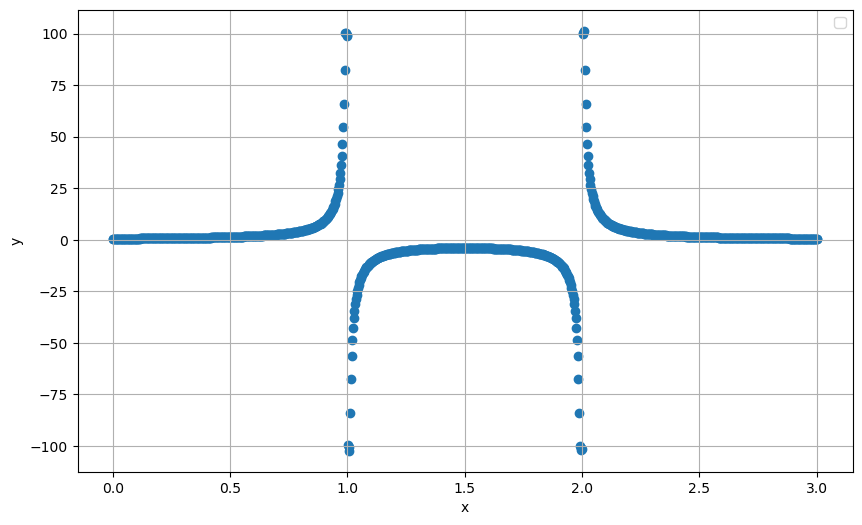

In [21]:
# plotting data
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.grid()
plt.show()

# Defining loss functions for regression

In [22]:
def rational(x, a, b, c, d):
    return (a * x + b) / (x**2 + c * x + d)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params):
    x, y = params
    a, b, c, d  = z
    return np.sum((rational(x, a, b, c, d) - y)**2)

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params):
    x, y = params
    a, b, c, d = z
    return rational(x, a, b, c, d) - y

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b, c, d):
    return np.sum((rational(x, a, b, c, d) - y)**2)

# Part 1

## Nelder-Mead

In [23]:
eps = 0.001
initial_guess = [0.1, 0.1, 0.1, 0.1]
nelder_mead = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = eps)

nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

## Levenberg-Marquardt

In [24]:
initial_guess = [-0.1, -0.1, 0.1, 0.1]
lma = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), ftol=eps, xtol=eps, method='lm')
lma_result = [len(lma['fun']), lma['nfev'], lma['cost']]

## Differential evolution

In [25]:
bounds = np.array([[-10, 10],[-10, 10],[-10, 10],[-10, 10]])
diff_evo = opt.differential_evolution(loss_rational, bounds, args=(x, y), tol=eps)
diff_evo_result = [diff_evo['nit'], diff_evo['nfev'], diff_evo['fun']]
diff_evo

 message: Optimization terminated successfully.
 success: True
     fun: 135602.0946712936
       x: [-9.913e-01  9.927e-01 -2.003e+00  1.003e+00]
     nit: 150
    nfev: 9125
     jac: [-1.065e+05 -1.081e+05 -2.158e+05 -1.889e+05]

## Swarm

In [26]:
lower_bound = np.array([-10]*4)
upper_bound = np.array([10]*4)
swam, fopt = pso(loss_rational, lower_bound, upper_bound, maxiter=1000, args=(x, y), swarmsize=1000, minfunc=0.001, debug=True)
swam = list(swam)

No constraints given.
Best after iteration 1: [ 0.62593873 -2.76883352  8.32909162 -9.30862582] 248901.54701741564
Best after iteration 2: [ 0.62593873 -2.76883352  8.32909162 -9.30862582] 248901.54701741564
Best after iteration 3: [ 0.62593873 -2.76883352  8.32909162 -9.30862582] 248901.54701741564
New best for swarm at iteration 4: [ -2.86888549   1.29663444   8.94705273 -10.        ] 242283.28184015345
Best after iteration 4: [ -2.86888549   1.29663444   8.94705273 -10.        ] 242283.28184015345
Best after iteration 5: [ -2.86888549   1.29663444   8.94705273 -10.        ] 242283.28184015345
Best after iteration 6: [ -2.86888549   1.29663444   8.94705273 -10.        ] 242283.28184015345
New best for swarm at iteration 7: [-1.81176922  0.97332829  8.88537614 -9.89149843] 232024.68317702026
New best for swarm at iteration 7: [ -2.87982298   0.43355142   8.98386478 -10.        ] 198092.83511780627
Best after iteration 7: [ -2.87982298   0.43355142   8.98386478 -10.        ] 198092.835

In [27]:
swarm_result = [145, 145, 197350.7498386208]

## Visualisation

# Part 2 - Application of Simulated Annealing method to solve the Travelling Salesman Problem

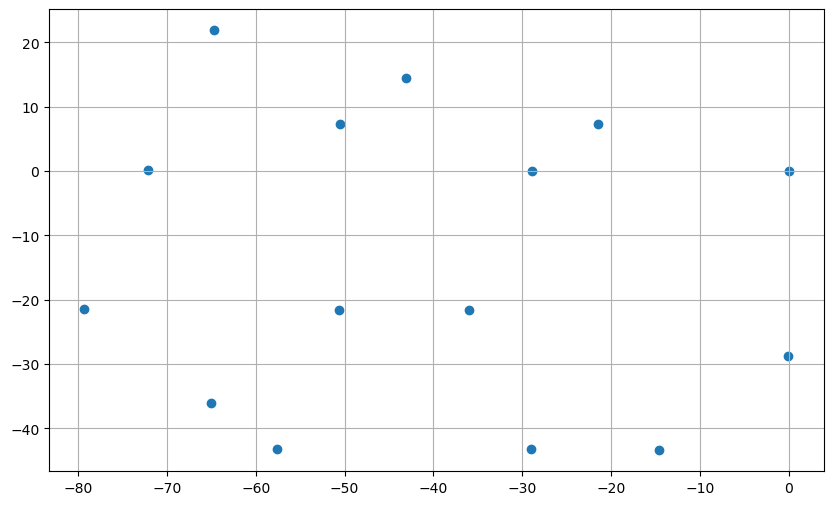

In [10]:
# load and read dataset
xy = np.loadtxt('Datasets/lau15_xy.txt')

x_cities, y_cities = np.split(xy, 2, axis=1)
x_cities = x_cities.flatten()
y_cities = y_cities.flatten()

plt.figure(figsize=(10,6))
plt.scatter(x_cities, y_cities)
plt.grid()

In [15]:
# distance matrix
distance_matrix = np.loadtxt('Datasets/lau15_dist.txt')

s = [[str(e) for e in row] for row in distance_matrix]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print('\n'.join(table))

0.0 	29.0	82.0	46.0	68.0	52.0	72.0	42.0	51.0	55.0	29.0	74.0	23.0	72.0	46.0
29.0	0.0 	55.0	46.0	42.0	43.0	43.0	23.0	23.0	31.0	41.0	51.0	11.0	52.0	21.0
82.0	55.0	0.0 	68.0	46.0	55.0	23.0	43.0	41.0	29.0	79.0	21.0	64.0	31.0	51.0
46.0	46.0	68.0	0.0 	82.0	15.0	72.0	31.0	62.0	42.0	21.0	51.0	51.0	43.0	64.0
68.0	42.0	46.0	82.0	0.0 	74.0	23.0	52.0	21.0	46.0	82.0	58.0	46.0	65.0	23.0
52.0	43.0	55.0	15.0	74.0	0.0 	61.0	23.0	55.0	31.0	33.0	37.0	51.0	29.0	59.0
72.0	43.0	23.0	72.0	23.0	61.0	0.0 	42.0	23.0	31.0	77.0	37.0	51.0	46.0	33.0
42.0	23.0	43.0	31.0	52.0	23.0	42.0	0.0 	33.0	15.0	37.0	33.0	33.0	31.0	37.0
51.0	23.0	41.0	62.0	21.0	55.0	23.0	33.0	0.0 	29.0	62.0	46.0	29.0	51.0	11.0
55.0	31.0	29.0	42.0	46.0	31.0	31.0	15.0	29.0	0.0 	51.0	21.0	41.0	23.0	37.0
29.0	41.0	79.0	21.0	82.0	33.0	77.0	37.0	62.0	51.0	0.0 	65.0	42.0	59.0	61.0
74.0	51.0	21.0	51.0	58.0	37.0	37.0	33.0	46.0	21.0	65.0	0.0 	61.0	11.0	55.0
23.0	11.0	64.0	51.0	46.0	51.0	51.0	33.0	29.0	41.0	42.0	61.0	0.0 	62.0	23.0
72.0	52.0	31.0	43.0	65.0	

## Visualisation

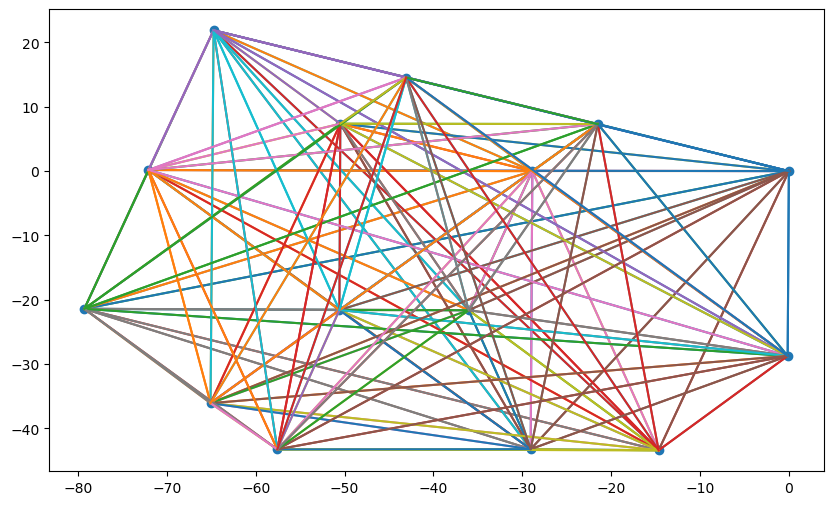

In [9]:
# The road from each city goes to each city
plt.figure(figsize=(10, 6))
plt.scatter(x_cities,y_cities)

for i in range(len(x_cities)):
    for j in range(len(x_cities)):
        plt.plot([x_cities[i],x_cities[j]], [y_cities[i], y_cities[j]])

## Annealing method

In [16]:
def total_dist(route, distance_matrix):
  d = 0.0
  n = len(route)
  for i in range(n-1):
    d += distance_matrix[route[i], route[i+1]]
  d += distance_matrix[route[n-1], route[0]]
  return d


def swap_random_elements(route):
  n = len(route)
  result = np.copy(route)
  i = np.random.randint(n)
  j = np.random.randint(n)
  tmp = result[i]
  result[i] = result[j]
  result[j] = tmp
  return result


def simulated_annealing_tsp(n_cities, distance_matrix, max_iter, curr_temperature, alpha):
  route = np.arange(n_cities, dtype=np.int64)
  np.random.shuffle(route)

  error = total_dist(route, distance_matrix)
  iteration = 0

  while iteration < max_iter:
    temp_route = swap_random_elements(route)
    temp_error = total_dist(temp_route, distance_matrix)

    if temp_error < error:
      route = temp_route
      error = temp_error
    else:
      diff = error - temp_error
      metropolis = np.exp(diff / curr_temperature)
      p = np.random.random()
      if p < metropolis:
        route = temp_route
        error = temp_error

    if curr_temperature <= 0:
      break
    else:
      curr_temperature *= alpha
    iteration += 1

  return route

In [17]:
num_cities = 15
max_iter = 1000
start_temperature = 1.0
alpha = 0.99
optim_guess = simulated_annealing_tsp(num_cities, distance_matrix, max_iter, start_temperature, alpha)

print(optim_guess)
dist = total_dist(optim_guess, distance_matrix)
print(dist)

[ 1 12  0 10  3  5  7  9 13 11  2  6  4  8 14]
291.0


## Result after optimization

100%|██████████| 14/14 [00:00<00:00, 2417.17it/s]


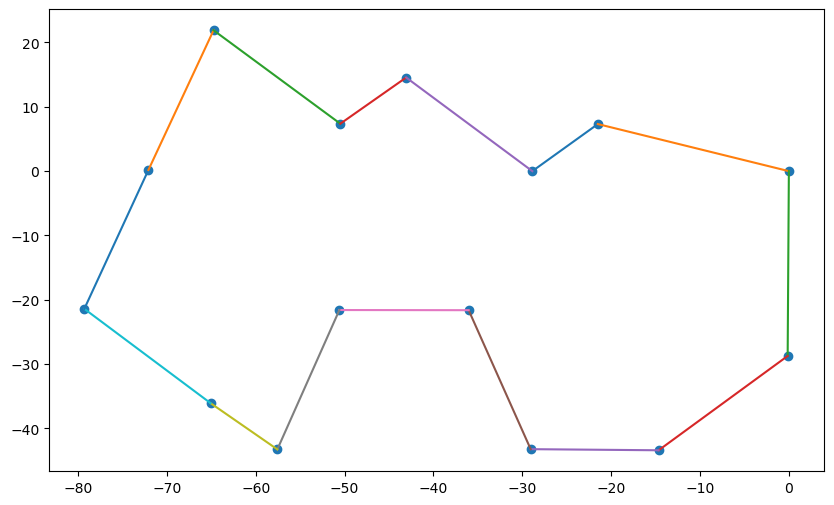

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(x_cities,y_cities)

for i in tqdm(range(len(optim_guess)-1)):
    idx1 = optim_guess[i]
    idx2 = optim_guess[i+1]
    plt.plot([x_cities[idx1], x_cities[idx2]], [y_cities[idx1], y_cities[idx2]])

idx1 = optim_guess[len(optim_guess)-1]
idx2 = optim_guess[0]
plt.plot([x_cities[idx2],x_cities[idx1]], [y_cities[idx2], y_cities[idx1]])

## Animated result

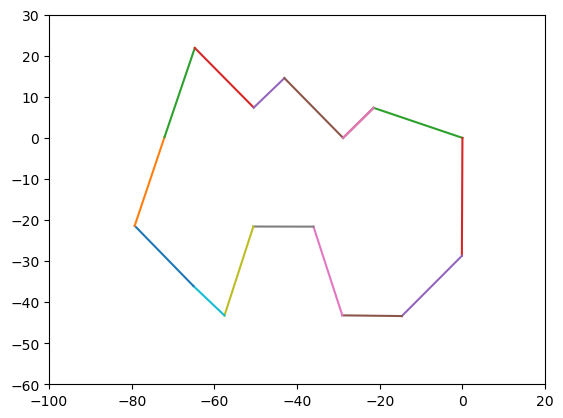

In [19]:
def animate(i):
    if i < 14:
        idx1 = optim_guess[i]
        idx2 = optim_guess[i+1]
        ax.plot([x_cities[idx1],x_cities[idx2]], [y_cities[idx1], y_cities[idx2]])
    else:
        idx1 = optim_guess[len(optim_guess)-1]
        idx2 = optim_guess[0]
        ax.plot([x_cities[idx2], x_cities[idx1]], [y_cities[idx2], y_cities[idx1]])


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display

fig, ax = plt.subplots()
ax.set_xlim([-100,20])
ax.set_ylim([-60,30])
ani = FuncAnimation(fig, animate, frames=15, interval=500, repeat=True)

display(HTML(ani.to_jshtml()))